зная центр опоры, можно попробовать ее повернуть и перевести в свою систему координат с началом в цетре нижней траверсы

In [31]:
from pathlib import Path
import geopandas as gpd
import csv
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, MultiPoint, Polygon

In [2]:
p = Path(r'/home/igor/Documents/some_tools/structure_samples/xyz')   # for linux

In [3]:
list_of_files = list(p.glob('*.xyz'))
for file in list_of_files:
    print(file.name)

sus_big.xyz
strain_3_lean_lo.xyz
d-pole_3x.xyz
substation.xyz
sus_5.xyz
st_220_5.xyz
sus_w_wires.xyz
s_pole.xyz
strain_sm.xyz
strain_2.xyz
strain_A_dpole_leaned.xyz
pole-w-guys_near_substation.xyz
sus_2pole_lean.xyz
s_pole_xarms.xyz
pole_asim_post.xyz
strain_A_dpole.xyz
2pole_supp_guys.xyz
pole_asim_3.xyz
st_220_6.xyz
sus_guyed_2x_steel.xyz
sus_220_6.xyz
3pole_guys.xyz
strain_big.xyz


In [4]:
spam_file = p / 'sus_5.xyz'
str = []
with spam_file.open() as f:
        spamreader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC, skipinitialspace=True)
        for row in spamreader:
            str.append(row)
str[:5]

[[1245959.75, 4851979.15, 20.32],
 [1245959.66, 4851979.11, 20.78],
 [1245959.55, 4851979.2, 21.36],
 [1245959.41, 4851979.79, 20.94],
 [1245959.46, 4851979.43, 21.48]]

In [11]:
# делаем массив np и обрезаю на треть снизу
np_str = np.array(str)
np_str_cut = np.delete(np_str, np_str[:,2]<((max(np_str[:,2])-min(np_str[:,2]))/3 + min(np_str[:,2])), 0)
len(np_str), len(np_str_cut)

(6214, 3262)

In [15]:
np_str_2d = np_str_cut[:,:2]   # x and y
np_str_z = np_str_cut[:,2]
print(np_str_2d[1], np_str_z[1])

[1245957.54 4851980.07] 30.29


(1245951.938, 1245957.9219999998, 4851977.639, 4851984.700999999)

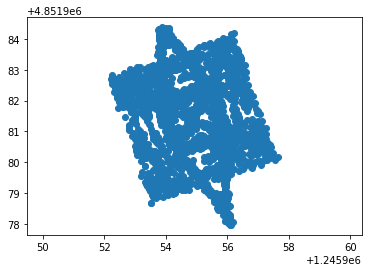

In [13]:
plt.scatter(np_str_2d[:,0], np_str_2d[:,1])
plt.axis('equal')

In [16]:
# needs to create new segmented list
segmented = []
segment_size = 0.1
start = min(np_str_z)
end = start + segment_size
while end < max(np_str_z):
    segmented.append(sum(end > i > start for i in np_str_z))
    start += segment_size
    end += segment_size

print(len(segmented))

194


In [17]:
# finding h by index:
indx = 15
h = min(np_str_z) + segment_size*indx

print(indx, segmented[indx], h, h+segment_size)

15 18 31.42 31.520000000000003


In [27]:
# отбираем сегметы со значениями больше определеного и записываем как пару номер сегмента + значение
ma = []
for nu, i in enumerate(segmented):
    if i > (np.mean(segmented))*2:
        ma.append((nu, i))

for i in ma:
    print(i)

(9, 116)
(10, 65)
(21, 75)
(22, 48)
(45, 53)
(79, 38)
(94, 110)
(95, 93)
(127, 186)
(128, 53)
(160, 212)
(161, 50)
(162, 35)
(169, 50)


In [21]:
# break for groups with lowest segment num and sum of points
ma2 = {}
low_level = 0
points_sum = 0

for i in range(len(ma)):
    #print(i, ma[i][0], ma[i][1])
    # если следующий сегмент также отобран
    if i != len(ma)-1 and ma[i][0]+1 == (ma[i+1][0]):
        points_sum += ma[i+1][1]
        
        # если предыдущий сегмент не был отобран 
        if i > 0 and not ma[i][0]-1 == (ma[i-1][0]):
            points_sum += ma[i][1]
            low_level = ma[i][0]
        
        ma2[low_level] = points_sum

    else:
        #print('skip')
        low_level = 0
        points_sum = 0
    
    #print(low_level, points_sum)
ma2

{0: 65, 21: 123, 94: 203, 127: 239, 160: 297}

In [26]:
#  из отобранных групп выделяем три наибольшие
# такой отбор не стаботает на траверсах постоянной высоты - там будет по два выброса на траверсу
selected = sorted(ma2.items(), key=lambda item: item[1])[-3:]
print(selected)

h_trav = []   # нижие кромки траверс
for i in selected:
    h_trav.append(round((min(np_str_z) + segment_size*i[0]), 1))
z1, z2, z3 = sorted(h_trav)[0], sorted(h_trav)[1], sorted(h_trav)[2]
print(z1, z2, z3)


[(94, 203), (127, 239), (160, 297)]
39.3 42.6 45.9


In [28]:
# cut the legs again
np_str_cut = np.delete(np_str_cut, np_str_cut[:,2]<(z1-0.1), 0)
np_str_cut 

array([[1.24595596e+06, 4.85197866e+06, 3.94200000e+01],
       [1.24595603e+06, 4.85197899e+06, 3.93900000e+01],
       [1.24595602e+06, 4.85197976e+06, 3.94000000e+01],
       ...,
       [1.24595385e+06, 4.85198430e+06, 4.59600000e+01],
       [1.24595382e+06, 4.85198414e+06, 4.60600000e+01],
       [1.24595379e+06, 4.85198398e+06, 4.61400000e+01]])

In [29]:
# will work with top part
n_s_1_mp = MultiPoint(np_str_cut)    # to multipoint (needs to shapely)
rect = n_s_1_mp.minimum_rotated_rectangle
rect_c = rect.centroid

(1245952.7895365779, 1245957.1446295725, 4851977.289769065, 4851985.031129883)

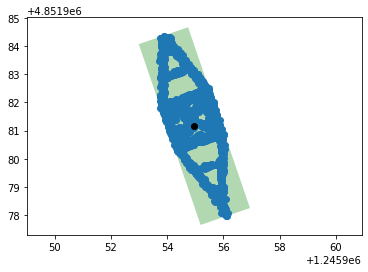

In [33]:
ax = gpd.GeoSeries(rect).plot(color='green', alpha=0.3)
plt.scatter(np_str_cut[:,0], np_str_cut[:,1])
gpd.GeoSeries(rect_c).plot(ax=ax, color='black')
plt.axis('equal')

In [34]:
# определим азимут и расстояние
from math import sqrt, acos, degrees

def azimuth(a, b):
    # by two points we get azimuth
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    dist = sqrt(dx*dx + dy*dy)    # dist a to b
    dx2 = abs(dx)
    beta = degrees(acos(dx2/dist))
    if dx > 0:
        if dy < 0:
            angle = 270 + beta
        else:
            angle = 270 - beta
    else:
        if dy < 0:
            angle = 90 - beta
        else:
            angle = 90 + beta

    return round(angle, 2), dist


In [35]:
# find a longest side and azimuth

side_a = azimuth(list(rect.exterior.coords)[0], list(rect.exterior.coords)[1])
side_b = azimuth(list(rect.exterior.coords)[1], list(rect.exterior.coords)[2])
if side_a[1] > side_b[1]:
    str_azmt = side_a[0]
else:
    str_azmt = side_b[0]

print(side_a)
print(side_b)
print(str_azmt)

(161.11, 6.8026700607985795)
(71.11, 1.8572203067145663)
161.11


In [ ]:


>>> from shapely.geometry import LineString as shLs
>>> from shapely.geometry import Point as shPt
>>> l = shLs([ (1,1), (3,1)])
>>> p = shPt(2,2)
>>> dist = p.distance(l)
1.0
>>> l.interpolate(dist).wkt
'POINT (2 1)'
